# PyTorch hardware benchmark analysis

Single node throughput comparisons between different hardware options at NERSC.

In [1]:
import os
import re
import glob

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
plt.rcParams.update({'font.size': 14})

## Load the results

In [30]:
ls /global/cscratch1/sd/sfarrell/pytorch-benchmarks/results

gpu-v1.5.0-nccl-n1/   gpu-v1.5.0-nccl-n8/   hsw-v1.5.0-mpi-n4/
gpu-v1.5.0-nccl-n16/  hsw-v1.5.0-mpi-n1/    hsw-v1.5.0-mpi-n64/
gpu-v1.5.0-nccl-n2/   hsw-v1.5.0-mpi-n128/  hsw-v1.5.0-mpi-n8/
gpu-v1.5.0-nccl-n32/  hsw-v1.5.0-mpi-n16/   knl-v1.5.0-mpi-n1/
gpu-v1.5.0-nccl-n4/   hsw-v1.5.0-mpi-n2/
gpu-v1.5.0-nccl-n64/  hsw-v1.5.0-mpi-n32/


In [31]:
pattern = '/global/cscratch1/sd/sfarrell/pytorch-benchmarks/results/%s-%s-%s-n1/results.txt'

In [32]:
version = 'v1.5.0'

In [33]:
results_files = (
    glob.glob(pattern % ('hsw', version, 'mpi')) +
    glob.glob(pattern % ('knl', version, 'mpi')) + 
    glob.glob(pattern % ('gpu', version, 'nccl'))
)
results_files

['/global/cscratch1/sd/sfarrell/pytorch-benchmarks/results/hsw-v1.5.0-mpi-n1/results.txt',
 '/global/cscratch1/sd/sfarrell/pytorch-benchmarks/results/knl-v1.5.0-mpi-n1/results.txt',
 '/global/cscratch1/sd/sfarrell/pytorch-benchmarks/results/gpu-v1.5.0-nccl-n1/results.txt']

In [34]:
results = [pd.read_csv(f, delim_whitespace=True) for f in results_files]
results = pd.concat(results, ignore_index=True)

results

,train_rate,inference_rate,ranks,hardware,version,backend,model
0,821.299625,2109.066161,1,hsw,v1.5.0,mpi,lstm
1,210.255378,708.869501,1,hsw,v1.5.0,mpi,alexnet
2,14.945649,54.003745,1,hsw,v1.5.0,mpi,resnet50
3,126.788587,284.274042,1,hsw,v1.5.0,mpi,cnn3d
4,237.164287,622.428353,1,knl,v1.5.0,mpi,lstm
5,148.210937,430.703021,1,knl,v1.5.0,mpi,alexnet
6,7.044788,57.519516,1,knl,v1.5.0,mpi,resnet50
7,42.725156,89.883285,1,knl,v1.5.0,mpi,cnn3d
8,7556.161027,14334.720501,1,gpu,v1.5.0,nccl,lstm
9,945.676066,2925.380300,1,gpu,v1.5.0,nccl,alexnet


## Tables

In [35]:
# Training rate per hardware
results.groupby('model').apply(lambda g: pd.Series(data=g.train_rate.values, index=g.hardware))

hardware,hsw,knl,gpu
model,,,
alexnet,210.255378,148.210937,945.676066
cnn3d,126.788587,42.725156,1786.002353
lstm,821.299625,237.164287,7556.161027
resnet50,14.945649,7.044788,298.138160


In [36]:
# Evaluation rate per hardware
results.groupby('model').apply(lambda g: pd.Series(data=g.inference_rate.values, index=g.hardware))

hardware,hsw,knl,gpu
model,,,
alexnet,708.869501,430.703021,2925.380300
cnn3d,284.274042,89.883285,9659.013527
lstm,2109.066161,622.428353,14334.720501
resnet50,54.003745,57.519516,933.466286


## Training throughput comparisons

In [37]:
#models = ['alexnet', 'vgg11', 'inceptionV3', 'resnet50', 'cnn3d', 'lstm']
models = ['alexnet', 'resnet50', 'cnn3d', 'lstm']
results_by_model = results.groupby('model')

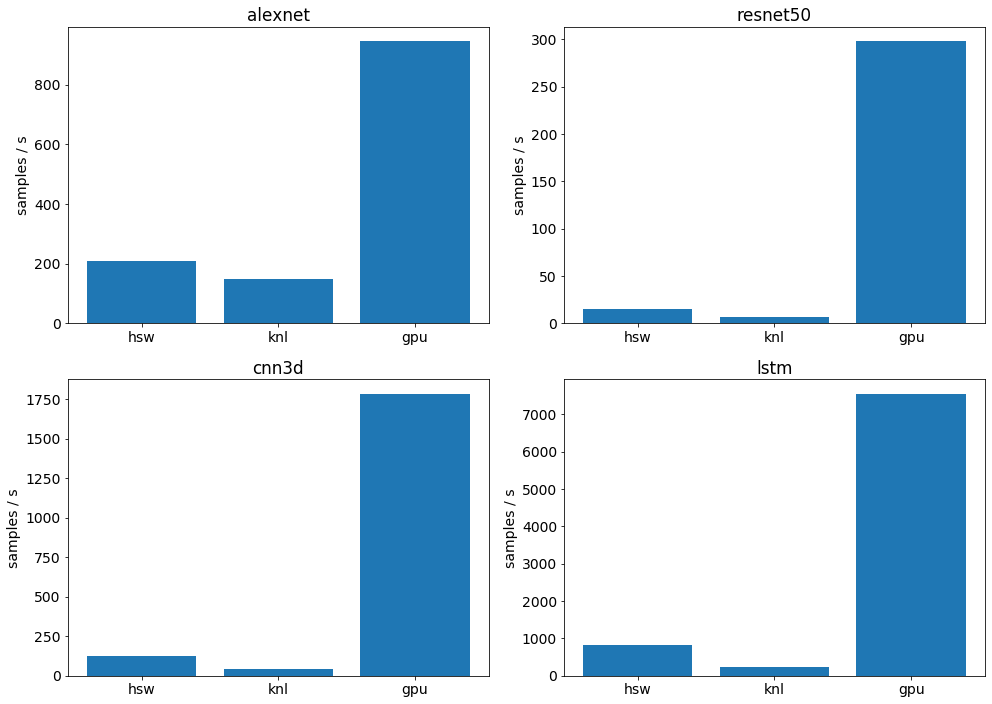

In [44]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axs = axs.flatten()

for i, model in enumerate(models):
    ax = axs[i]
    model_results = results_by_model.get_group(model)
    ax.bar(model_results.hardware, model_results.train_rate, log=False)
    ax.set_title(model)
    ax.set_ylabel('samples / s')

plt.tight_layout()